# Setup

In [1]:
%%capture
!pip install --upgrade pypair
!pip install --upgrade scikit-learn

Importing libraries:

In [2]:
import gc
gc.enable()

import warnings
warnings.filterwarnings('ignore')

import time
import joblib
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pypair.association import (
    binary_continuous, 
    binary_binary
)
from sklearn.feature_selection import (
    chi2, 
    f_classif, 
    mutual_info_classif
)
from sklearn.metrics import (
    make_scorer,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    TunedThresholdClassifierCV
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

SEED = 2024

In [3]:
data = pd.read_csv('train.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


### Target

In [5]:
TARGET = 'Response'
data[TARGET].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: Response, dtype: float64

### Missing values

In [6]:
data.isna().sum().sum()

0

### Duplicate rows

In [7]:
data.duplicated().sum()

0

**Without TARGET**: repeated customers

In [8]:
data.duplicated(subset=[f for f in data.columns if f != TARGET]).sum()

0

**Without *id***: similar features with same outcomes

In [9]:
data.duplicated(subset=[f for f in data.columns if f != 'id']).sum()

269

**Without *id* and TARGET**: similar features with same or different outcomes

In [10]:
data.duplicated(subset=[f for f in data.columns if f not in ('id', TARGET)]).sum()

322

In [11]:
duplicates = data.duplicated(subset=[f for f in data.columns if f not in ('id', TARGET)])
data.loc[duplicates][TARGET].value_counts(normalize=True)

0    0.84472
1    0.15528
Name: Response, dtype: float64

In [12]:
data = data.drop_duplicates(
    subset=[f for f in data.columns if f not in ('id', TARGET)], 
    ignore_index=True,
    keep='first'
)

In [13]:
data[TARGET].value_counts(normalize=True)

0    0.877464
1    0.122536
Name: Response, dtype: float64

Class ratio maintained.

# Feature exploration & preprocessing

### id

In [14]:
data.shape[0], data.id.nunique()

(380787, 380787)

### Gender

In [15]:
data.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [16]:
data.Gender.value_counts(normalize=True)

Male      0.540743
Female    0.459257
Name: Gender, dtype: float64

Balanced distribution.

In [17]:
data.groupby('Gender')[TARGET].value_counts(normalize=True)

Gender  Response
Female  0           0.896140
        1           0.103860
Male    0           0.861603
        1           0.138397
Name: Response, dtype: float64

In [18]:
data['Gender'] = data.Gender.replace({'Female': 0, 'Male': 1})

### Age

In [19]:
data.Age.describe()

count    380787.000000
mean         38.822951
std          15.513783
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64

In [20]:
def plot_numerical(f, dataset=data):
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    plt.suptitle(f'{f}')
    ax[0].set_title('Feature distribution split by target')
    sns.kdeplot(data=dataset, x=f, hue=TARGET, cut=0, bw_adjust=1.5, ax=ax[0])
    ax[1].set_title('Feature distribution for positive class')
    sns.kdeplot(data=dataset[dataset[TARGET]==1], x=f, cut=0, bw_adjust=1.5, ax=ax[1])
    fig.tight_layout()
    plt.show()

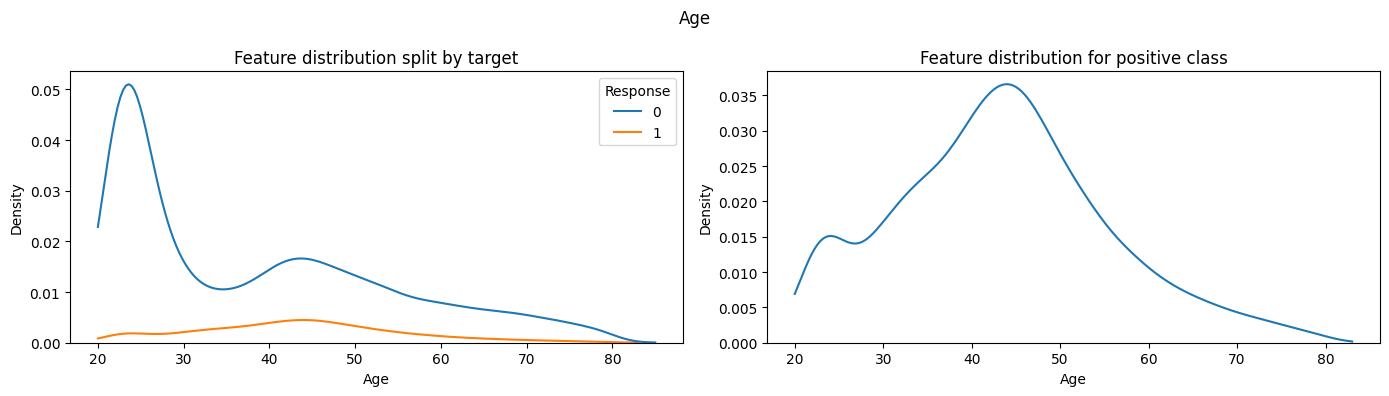

In [21]:
plot_numerical('Age')

In [22]:
data.query("Age <= 27")[TARGET].value_counts(normalize=True), data.query("Age > 27")[TARGET].value_counts(normalize=True)

(0    0.96395
 1    0.03605
 Name: Response, dtype: float64,
 0    0.827915
 1    0.172085
 Name: Response, dtype: float64)

### Driving_License

In [23]:
data.Driving_License.unique()

array([1, 0])

In [24]:
data.Driving_License.value_counts(normalize=True)

1    0.997868
0    0.002132
Name: Driving_License, dtype: float64

Extremely imbalanced feature -> low variance.  
Might not be very informative on its own.

In [25]:
data.groupby('Driving_License')[TARGET].value_counts(normalize=True)

Driving_License  Response
0                0           0.949507
                 1           0.050493
1                0           0.877310
                 1           0.122690
Name: Response, dtype: float64

In [26]:
data.groupby('Driving_License')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Driving_License,,,,,,,,
0,812.0,65.604680,10.479509,21.0,59.75,67.0,74.0,85.0
1,379975.0,38.765719,15.473246,20.0,25.00,36.0,49.0,85.0


### Region_Code

In [27]:
data.Region_Code.nunique()

53

In [28]:
data.Region_Code.unique()[:10]

array([28.,  3., 11., 41., 33.,  6., 35., 50., 15., 45.])

We can treat this feature as numerical for modeling purposes.

In [29]:
data.groupby('Region_Code')[TARGET].value_counts()[:10]

Region_Code  Response
0.0          0           1840
             1            174
1.0          0            897
             1            109
2.0          0           3750
             1            287
3.0          0           8064
             1           1179
4.0          0           1513
             1            285
Name: Response, dtype: int64

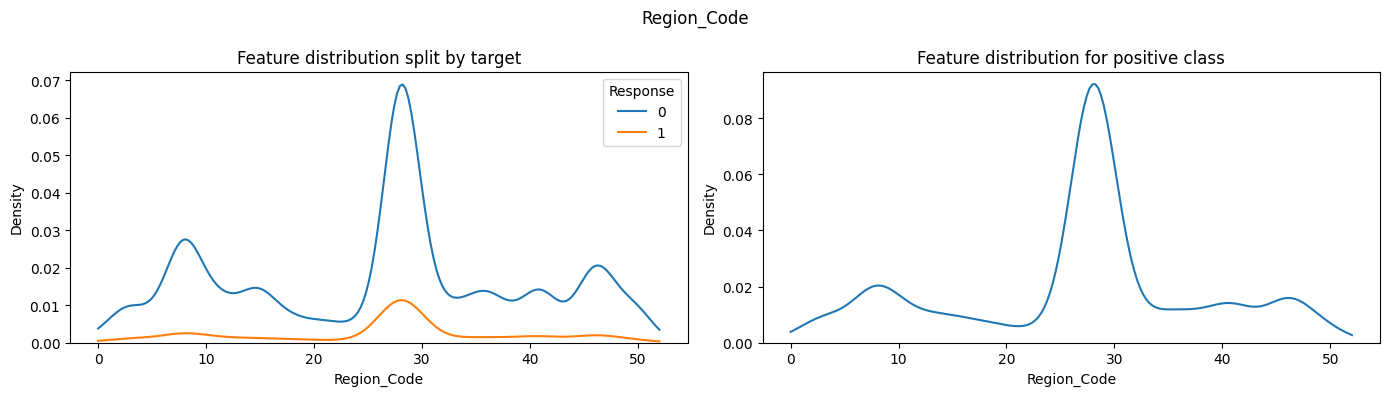

In [30]:
plot_numerical('Region_Code')

### Previously_Insured

In [31]:
data.Previously_Insured.unique()

array([0, 1])

In [32]:
data.Previously_Insured.value_counts(normalize=True)

0    0.541728
1    0.458272
Name: Previously_Insured, dtype: float64

In [33]:
data.groupby('Previously_Insured')[TARGET].value_counts(normalize=True)

Previously_Insured  Response
0                   0           0.774572
                    1           0.225428
1                   0           0.999095
                    1           0.000905
Name: Response, dtype: float64

Very strong indicator based on target splits.

### Vehicle_Age

In [34]:
data.Vehicle_Age.unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [35]:
data.Vehicle_Age.value_counts(normalize=True)

1-2 Year     0.525546
< 1 Year     0.432433
> 2 Years    0.042021
Name: Vehicle_Age, dtype: float64

In [36]:
data.groupby('Vehicle_Age')[TARGET].value_counts(normalize=True)

Vehicle_Age  Response
1-2 Year     0           0.826295
             1           0.173705
< 1 Year     0           0.956287
             1           0.043713
> 2 Years    0           0.706268
             1           0.293732
Name: Response, dtype: float64

* Ordinal relation between the categories.
* Target splits show an ordinal relation too -> Can be a numerical feature for some models.

In [37]:
data['Vehicle_Age'] = data.Vehicle_Age.replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

### Vehicle_Damage

In [38]:
data.Vehicle_Damage.unique()

array(['Yes', 'No'], dtype=object)

In [39]:
data.Vehicle_Damage.value_counts(normalize=True)

Yes    0.504807
No     0.495193
Name: Vehicle_Damage, dtype: float64

In [40]:
data.groupby('Vehicle_Damage')[TARGET].value_counts(normalize=True)

Vehicle_Damage  Response
No              0           0.994792
                1           0.005208
Yes             0           0.762371
                1           0.237629
Name: Response, dtype: float64

Strong indicator based on target-based split.

In [41]:
data['Vehicle_Damage'] = data.Vehicle_Damage.replace({'No': 0, 'Yes': 1})

### Annual_Premium

In [42]:
data.Annual_Premium.describe()

count    380787.000000
mean      30587.906869
std       17201.294205
min        2630.000000
25%       24430.000000
50%       31680.000000
75%       39409.000000
max      540165.000000
Name: Annual_Premium, dtype: float64

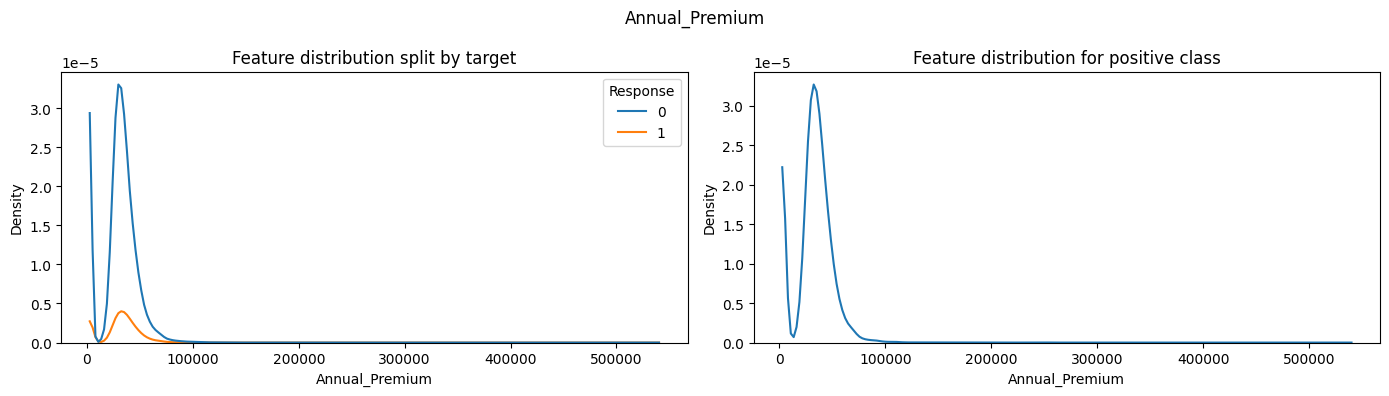

In [43]:
plot_numerical('Annual_Premium')

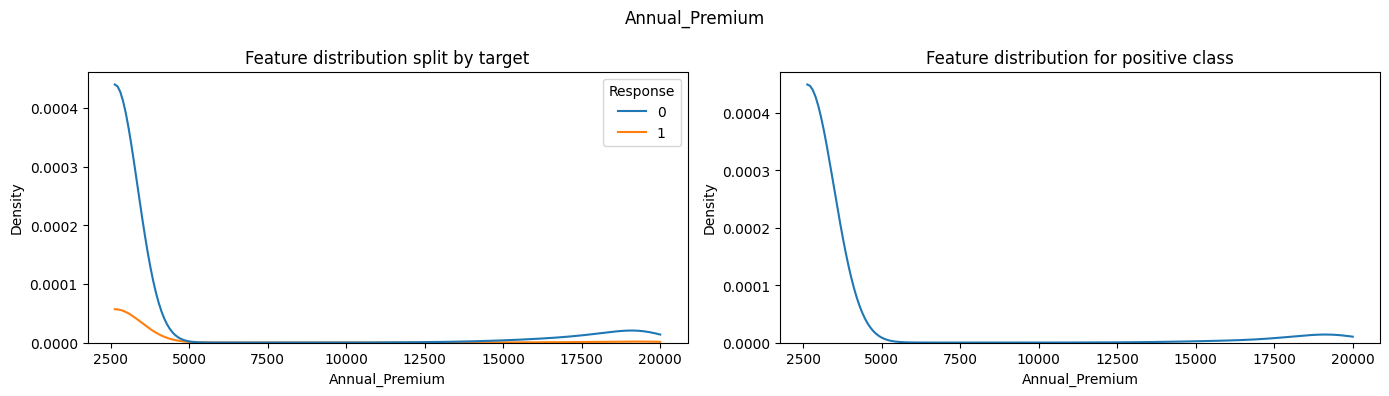

In [44]:
plot_numerical('Annual_Premium', data.query("Annual_Premium < 2e4"))

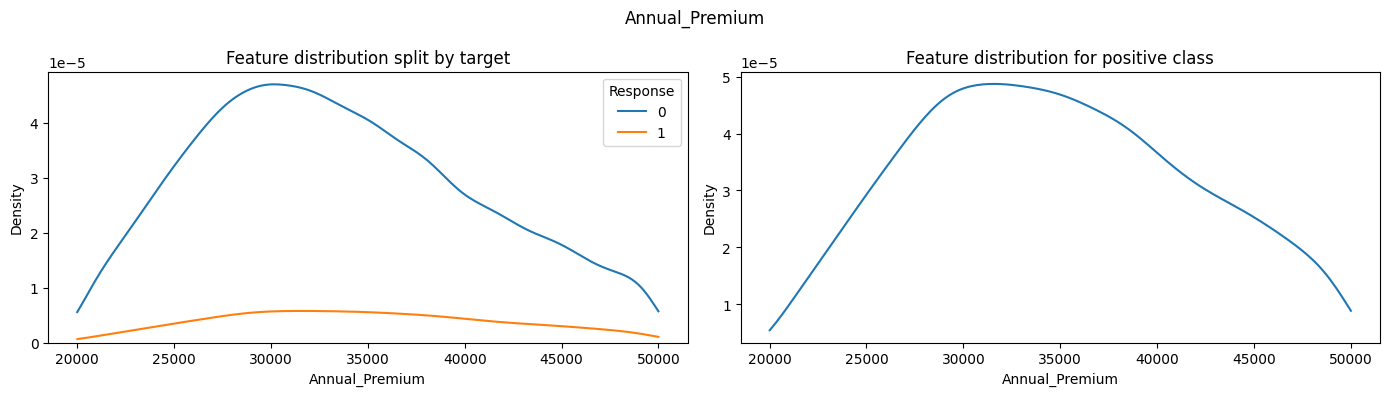

In [45]:
plot_numerical('Annual_Premium', data.query("2e4 < Annual_Premium < 5e4"))

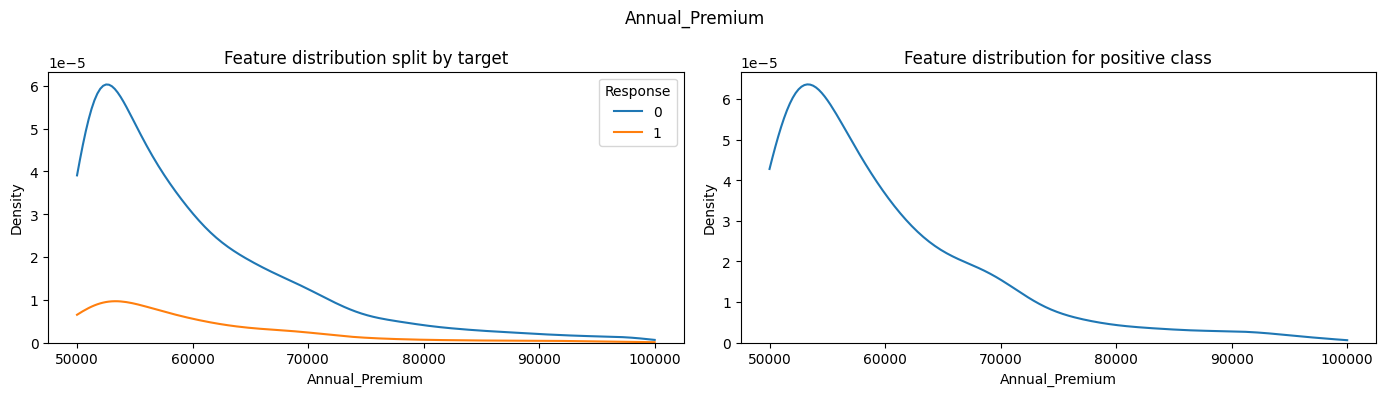

In [46]:
plot_numerical('Annual_Premium', data.query("5e4 < Annual_Premium < 1e5"))

### Policy_Sales_Channel

In [47]:
data.Policy_Sales_Channel.nunique()

155

In [48]:
data.Policy_Sales_Channel.unique()[:10]

array([ 26., 152., 160., 124.,  14.,  13.,  30., 156., 163., 157.])

Again, a categorical feature with high-cardinality, which can be treated like a numerical feature.

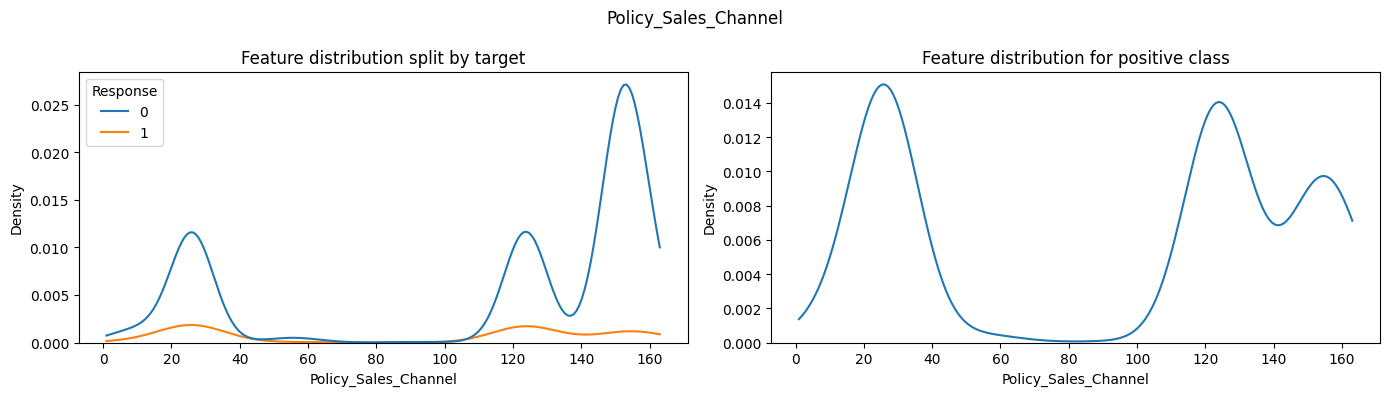

In [49]:
plot_numerical('Policy_Sales_Channel')

### Vintage

In [50]:
data.Vintage.describe()

count    380787.000000
mean        154.344844
std          83.669560
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

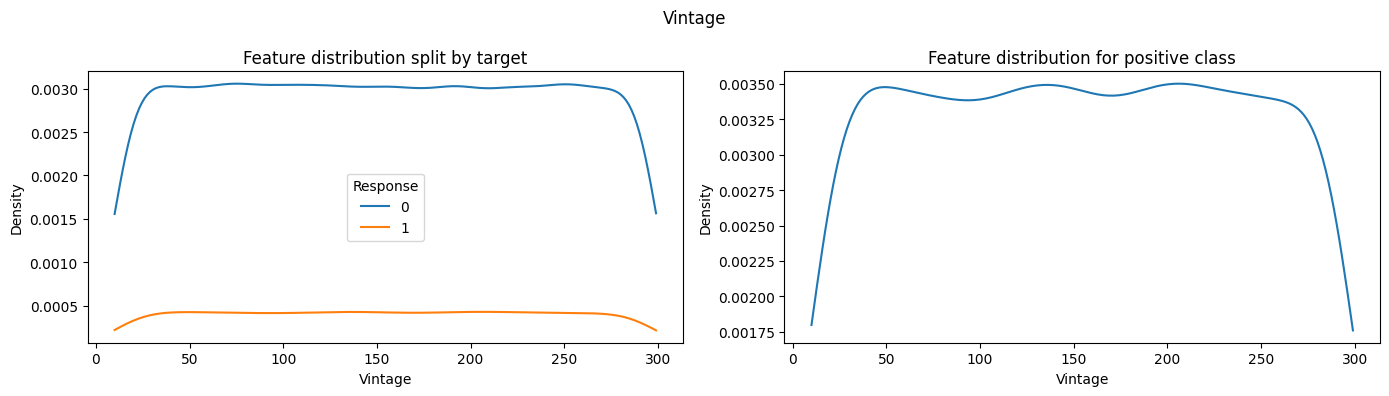

In [51]:
plot_numerical('Vintage')

Uniform distribution and no target-based splits.

# Feature engineering

### age_group

In [52]:
data['age_group'] = (data['Age'] > 27).astype('int')

In [53]:
data.age_group.value_counts(normalize=True)

1    0.635762
0    0.364238
Name: age_group, dtype: float64

In [54]:
data.groupby('age_group')[TARGET].value_counts(normalize=True)

age_group  Response
0          0           0.963950
           1           0.036050
1          0           0.827915
           1           0.172085
Name: Response, dtype: float64

### policy_channel_group

In [55]:
data['policy_channel_group'] = (data['Policy_Sales_Channel'] >= 140).astype('int')

In [56]:
data.policy_channel_group.value_counts(normalize=True)

0    0.501606
1    0.498394
Name: policy_channel_group, dtype: float64

In [57]:
data.groupby('policy_channel_group')[TARGET].value_counts(normalize=True)

policy_channel_group  Response
0                     0           0.816476
                      1           0.183524
1                     0           0.938846
                      1           0.061154
Name: Response, dtype: float64

# Bivariate analysis

In [58]:
features = [f for f in data.columns if f not in ('id', TARGET)]
numerical_features = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
categorical_features = [f for f in features if f not in numerical_features]

### Pairplots (numerical features)

<Figure size 1400x900 with 0 Axes>

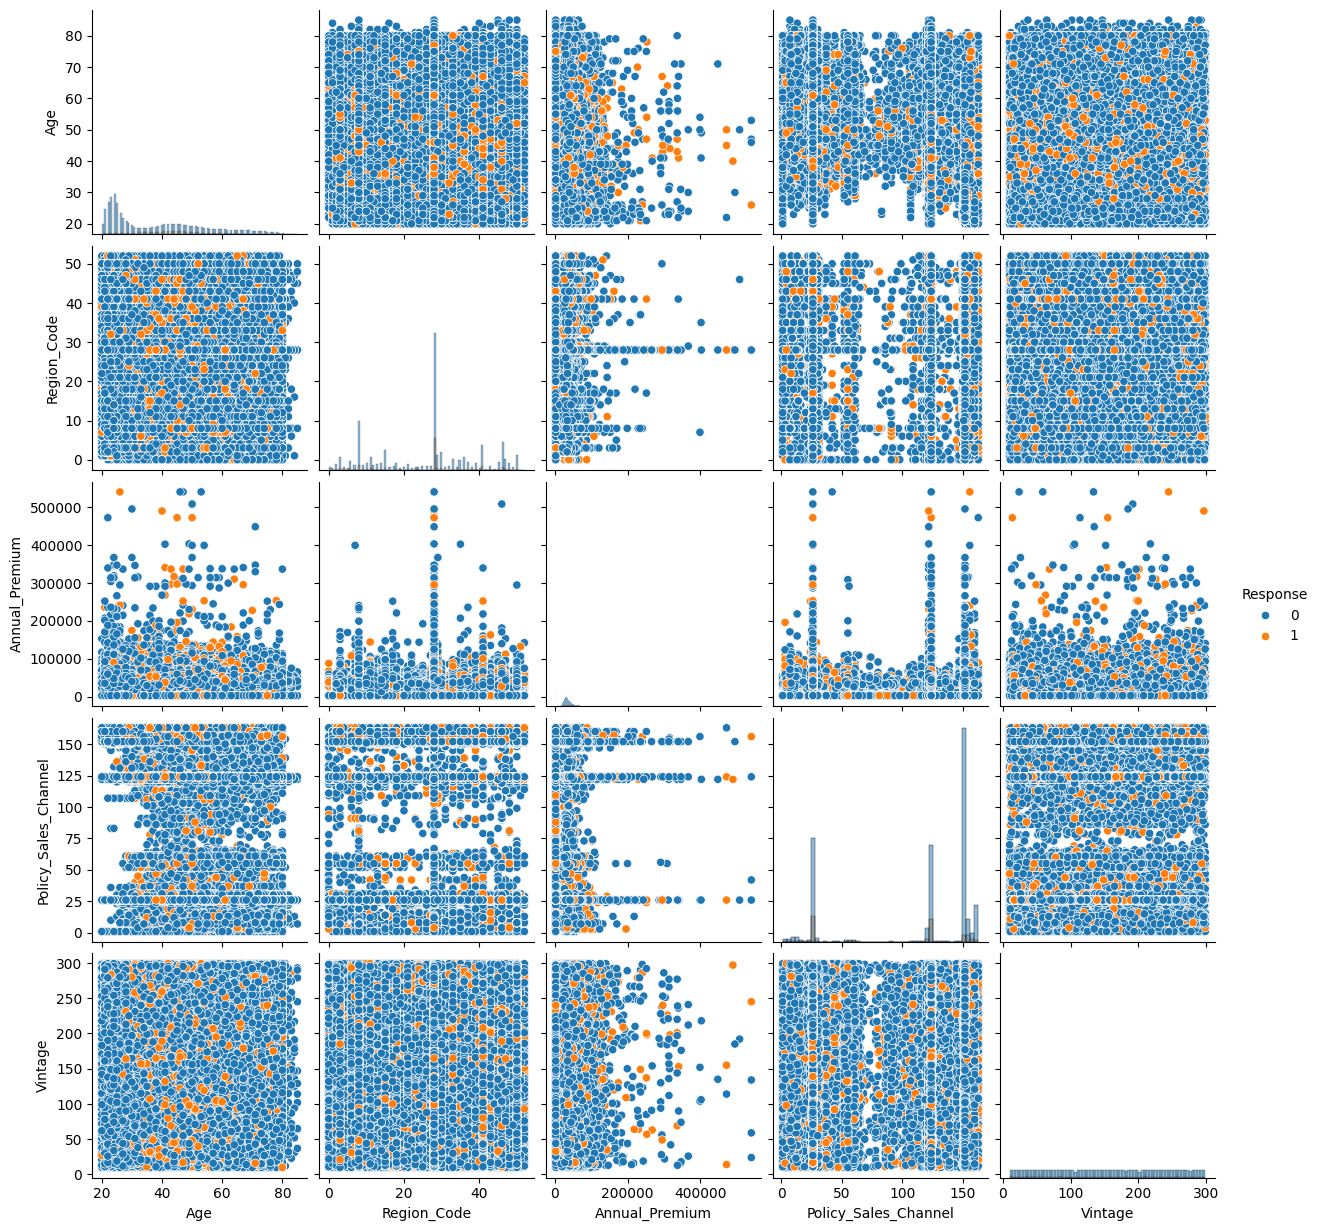

In [59]:
plt.figure(figsize=(14, 9))
sns.pairplot(data=data, kind='scatter', diag_kind='hist', vars=numerical_features, hue=TARGET)
plt.show()

### Spearman correlation (numerical features)

In [60]:
def plot_heatmap(df, masking=False, size=4):
    mask = np.triu(np.ones_like(df)) if masking else None
    plt.figure(figsize=(size, size * 0.75))
    sns.heatmap(
        data=df, mask=mask,
        vmin=-1, vmax=1, center=0,
        annot=True, linewidths=0.1,
        fmt='.2f', annot_kws={'fontsize': 8})
    plt.show()

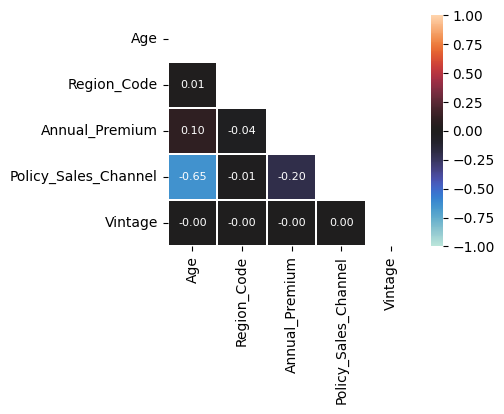

In [61]:
corr_df = data[numerical_features].corr(method='spearman')
plot_heatmap(corr_df, masking=True)

### Point-biserial correlation (binary vs numerical)

In [62]:
# all the categorical features are binary
pbsr_dict = {}
for bf in categorical_features:
    pbsr = [binary_continuous(data[bf], data[nf], measure='point_biserial')
            for nf in numerical_features]
    pbsr_dict[bf] = pbsr

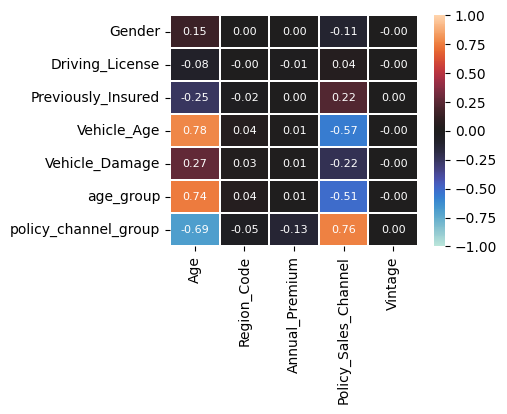

In [63]:
pbsr_df = pd.DataFrame.from_dict(pbsr_dict, orient='index', columns=numerical_features)
plot_heatmap(pbsr_df)

Moderate and strong correlations between several pairs.

### Tetrachoric correlation (binary features)

In [64]:
tetra_dict = {}
for cf1 in categorical_features:
    corr = [binary_binary(data[cf1], data[cf2], measure='tetrachoric')
            for cf2 in categorical_features]
    tetra_dict[cf1] = corr

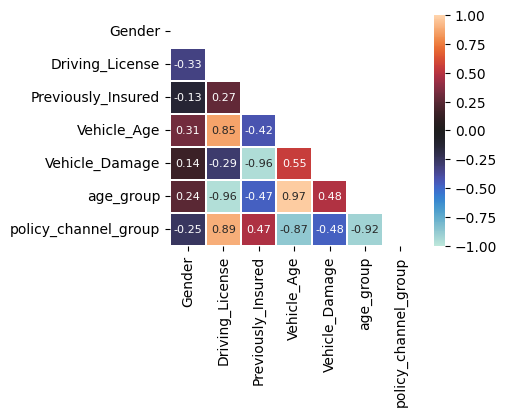

In [65]:
tetra_df = pd.DataFrame.from_dict(tetra_dict, orient='index', columns=categorical_features)
plot_heatmap(tetra_df, masking=True)

# Feature selection

In [66]:
def plot_bars(scores, title):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, len(scores)*0.5))
    ax.set_title(title)
    sns.barplot(x=scores.values, y=scores.index, ax=ax)
    for patch in ax.patches:
        y, height, width = patch.get_y(), patch.get_height(), patch.get_width()
        ax.text(
            width+0.0001, y + height/2, 
            f'{width:.4f}', va='center', ha='left', size=8, 
            bbox={'facecolor': 'white', 'boxstyle': 'round'}
        )

### Point-biserial correlation (Binary target vs Numerical features)

In [67]:
pbsr = [binary_continuous(data[TARGET], data[nf], measure='point_biserial')
        for nf in numerical_features]

pbsr = pd.Series(pbsr, index=numerical_features).sort_values(ascending=False)

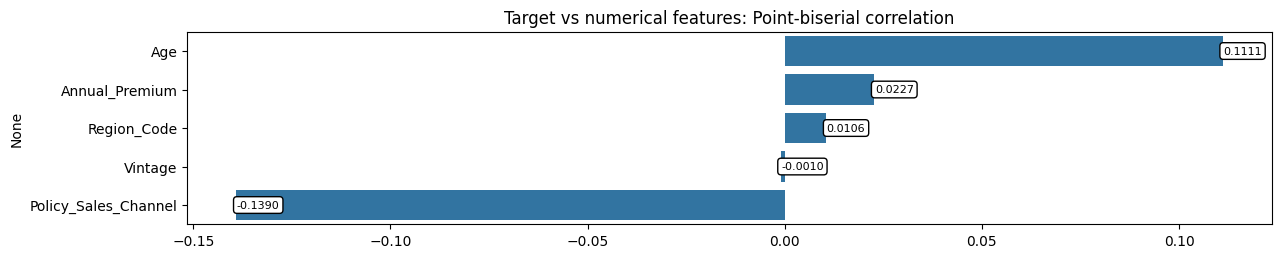

In [68]:
title = 'Target vs numerical features: Point-biserial correlation'
plot_bars(pbsr, title)

### ANOVA F-test (Categorical target vs Numerical features)

In [69]:
anova_test = f_classif(data[numerical_features], data[TARGET])

In [70]:
pd.DataFrame(
    data={
        'f-statistic': anova_test[0], 
        'p-value': anova_test[1],
        'accepted?': anova_test[1] < 0.05
    },
    index=numerical_features
).sort_values(by='f-statistic')

,f-statistic,p-value,accepted?
Vintage,0.399327,5.274375e-01,False
Region_Code,42.392837,7.475523e-11,True
Annual_Premium,196.877522,1.028994e-44,True
Age,4758.922048,0.000000e+00,True
Policy_Sales_Channel,7506.802491,0.000000e+00,True


### Tetrachoric correlation

In [71]:
tetra = [binary_binary(data[TARGET], data[bf], measure='tetrachoric')
        for bf in categorical_features]

tetra = pd.Series(tetra, index=categorical_features).sort_values(ascending=False)

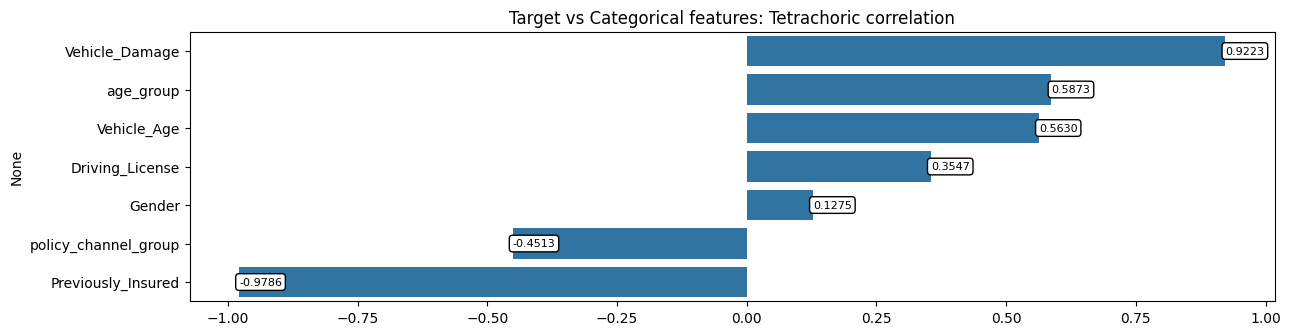

In [72]:
title = 'Target vs Categorical features: Tetrachoric correlation'
plot_bars(tetra, title)

### Chi-squared test of independence (Categorical target vs Categorical features)

In [73]:
chi2_test = chi2(data[categorical_features], data[TARGET])

In [74]:
pd.DataFrame(
    data={
        'chi2-statistic': chi2_test[0], 
        'p-value': chi2_test[1],
        'accepted?': chi2_test[1] < 0.05
    },
    index=categorical_features
).sort_values(by='chi2-statistic')

,chi2-statistic,p-value,accepted?
Driving_License,0.083762,7.722619e-01,False
Gender,481.776676,8.772924e-107,True
age_group,5527.843218,0.000000e+00,True
policy_channel_group,6650.210134,0.000000e+00,True
Vehicle_Age,9899.654778,0.000000e+00,True
Vehicle_Damage,23681.857822,0.000000e+00,True
Previously_Insured,24010.249114,0.000000e+00,True


### Mutual information score

In [75]:
#boolean mask for discrete features
cat_mask = [(f in categorical_features) for f in features]

mi_scores = mutual_info_classif(
    data[features], data[TARGET], 
    discrete_features=cat_mask, 
    random_state=SEED
)

mi_scores = pd.Series(mi_scores, index=features).sort_values(ascending=False)

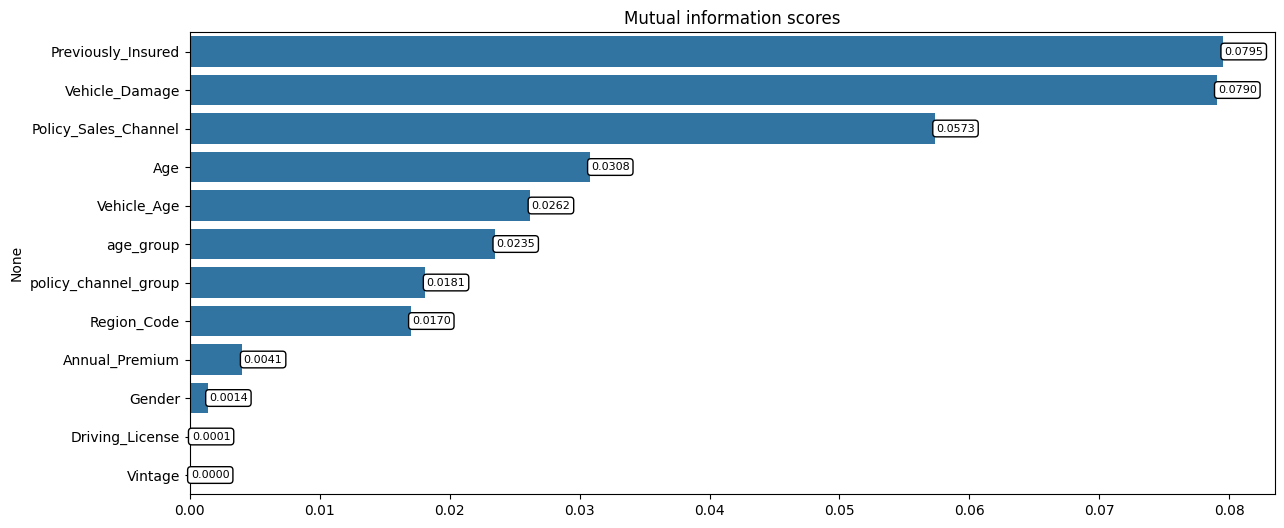

In [76]:
plot_bars(mi_scores, 'Mutual information scores')

### Model-based feature importances

XGBoost

In [77]:
model = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    scale_pos_weight=88/12,  # class ratio
    random_state=SEED,
    n_jobs=-1
)
model.fit(data[features], data[TARGET])

fimp = pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values(ascending=False)

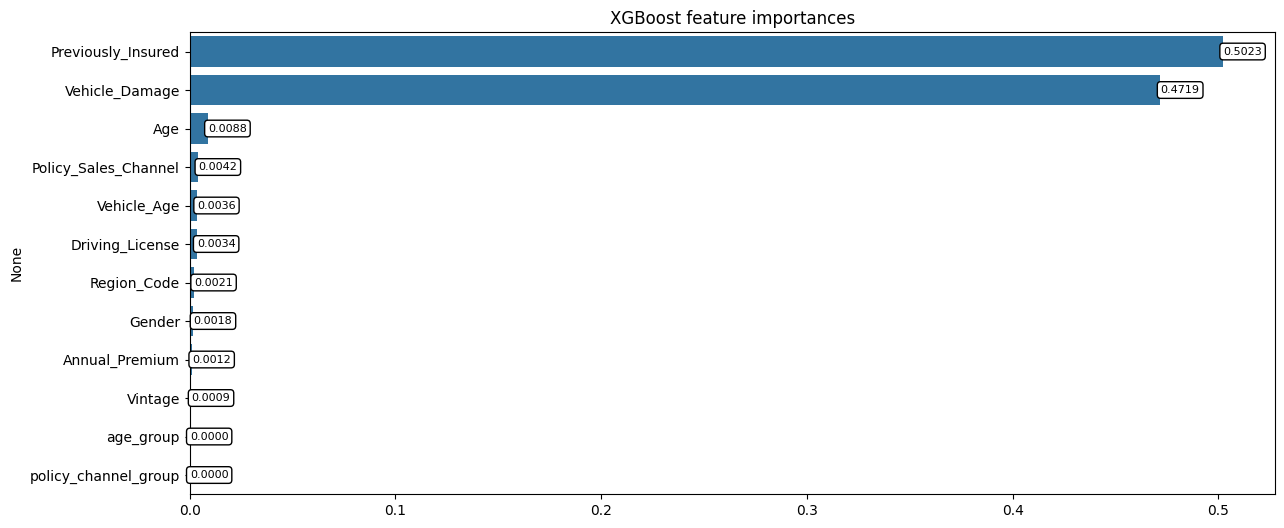

In [78]:
plot_bars(fimp, 'XGBoost feature importances')

ExtraTrees:

In [79]:
model = ExtraTreesClassifier(
    n_estimators=150, 
    max_depth=6, 
    max_features=None, 
    class_weight='balanced', 
    random_state=SEED,
    n_jobs=-1
)
model.fit(data[features], data[TARGET])

fimp = pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values(ascending=False)

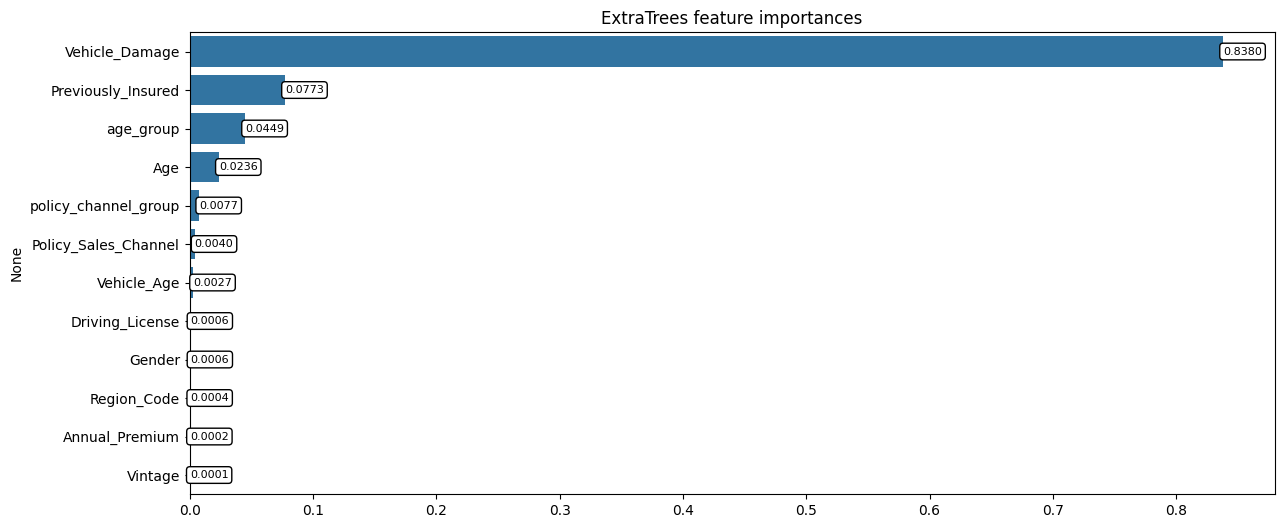

In [80]:
plot_bars(fimp, 'ExtraTrees feature importances')

### Feature sets

Based on statistical tests we discard some features:

In [81]:
reduced_features = [f for f in features 
                    if f not in ('Vintage', 'Driving_License')]

Based on correlation and feature importances, we further remove redundant features: 

In [82]:
minimal_features = [f for f in reduced_features
                    if f not in ('age_group', 'Vehicle_Damage')]

In [83]:
original_features = [f for f in features 
                     if f not in ('age_group', 'policy_channel_group')]

In [84]:
feature_sets = {
    'Original': original_features,
    'Extended': features,
    'Reduced': reduced_features,
    'Minimal': minimal_features
}

In [85]:
for fname, fset in feature_sets.items():
    print(f'{fname} features: {fset}\n')

Original features: ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

Extended features: ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'age_group', 'policy_channel_group']

Reduced features: ['Gender', 'Age', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'age_group', 'policy_channel_group']

Minimal features: ['Gender', 'Age', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Annual_Premium', 'Policy_Sales_Channel', 'policy_channel_group']



# Modeling framework

### Hold-out set for testing

In [86]:
train, test, _, _ = train_test_split(
    data, data[TARGET],
    stratify=data[TARGET],
    test_size=0.2,
    shuffle=True,
    random_state=SEED
)

### Cross-validation + Threshold tuning + Refit

In [87]:
def cv_tune_refit(estimator, feature_set, num_folds=7):
    global train, TARGET
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)
    model = TunedThresholdClassifierCV(
        estimator=estimator,
        scoring='f1',  # binary f1-score
        thresholds=100,
        cv=skf,
        refit=True,
        n_jobs=-1,
        random_state=SEED
    )
    model.fit(train[feature_set], train[TARGET])
    
    return model

### Model evaluation on test set

In [88]:
def evaluate(model, feature_set):
    global test, TARGET
    
    probs = model.predict_proba(test[feature_set])[:, 1]
    auc = roc_auc_score(test[TARGET], probs)
    preds = model.predict(test[feature_set])
    mcc = matthews_corrcoef(test[TARGET], preds)
    print(f'(Best threshold = {model.best_threshold_:.2f})')
    print(f' Area under ROC curve: {auc:.4f}')
    print(f' Matthew\'s Corr-coeff: {mcc:.4f}')
    print('\nClassification report:')
    print(classification_report(test[TARGET], preds, digits=4))

In [89]:
def run_experiment(estimator, model_name, save=True):
    global feature_sets
    
    for fname, fset in feature_sets.items():
        print('\n', '-'*15, 'Feature set: ', fname, '-'*15, '\n')
        start_time = time.time()
        model = cv_tune_refit(estimator, fset)
        evaluate(model, fset)
        end_time = time.time()
        print(f'\n(Time taken: {end_time - start_time:.2f} secs)')
        
        if save:
            save_path = f'mdl{model_name}_fs{fname}.joblib'
            joblib.dump(model, save_path)

# Logistic Regression

In [90]:
logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        penalty=None,
        tol=2e-4,
        max_iter=1000,
        solver='saga',
        class_weight='balanced',
        random_state=SEED
    )
)

run_experiment(logreg, 'LogReg')


 --------------- Feature set:  Original --------------- 

(Best threshold = 0.65)
 Area under ROC curve: 0.8336
 Matthew's Corr-coeff: 0.3671

Classification report:
              precision    recall  f1-score   support

           0     0.9598    0.7454    0.8391     66826
           1     0.2986    0.7761    0.4313      9332

    accuracy                         0.7492     76158
   macro avg     0.6292    0.7608    0.6352     76158
weighted avg     0.8787    0.7492    0.7891     76158


(Time taken: 4.28 secs)

 --------------- Feature set:  Extended --------------- 

(Best threshold = 0.66)
 Area under ROC curve: 0.8456
 Matthew's Corr-coeff: 0.3821

Classification report:
              precision    recall  f1-score   support

           0     0.9619    0.7540    0.8454     66826
           1     0.3085    0.7859    0.4431      9332

    accuracy                         0.7579     76158
   macro avg     0.6352    0.7700    0.6442     76158
weighted avg     0.8818    0.7579    0.796

# Linear Discriminant Analysis

In [91]:
lda = make_pipeline(
    StandardScaler(),
    LinearDiscriminantAnalysis(solver='svd', tol=2e-4)
)

run_experiment(lda, 'LDA')


 --------------- Feature set:  Original --------------- 

(Best threshold = 0.19)
 Area under ROC curve: 0.8326
 Matthew's Corr-coeff: 0.3584

Classification report:
              precision    recall  f1-score   support

           0     0.9539    0.7640    0.8484     66826
           1     0.3032    0.7355    0.4294      9332

    accuracy                         0.7605     76158
   macro avg     0.6286    0.7498    0.6389     76158
weighted avg     0.8742    0.7605    0.7971     76158


(Time taken: 2.09 secs)

 --------------- Feature set:  Extended --------------- 

(Best threshold = 0.18)
 Area under ROC curve: 0.8423
 Matthew's Corr-coeff: 0.3785

Classification report:
              precision    recall  f1-score   support

           0     0.9630    0.7442    0.8396     66826
           1     0.3027    0.7951    0.4385      9332

    accuracy                         0.7504     76158
   macro avg     0.6328    0.7697    0.6390     76158
weighted avg     0.8821    0.7504    0.790

# 

# Quadratic Discriminant Analysis

In [92]:
qda = make_pipeline(
    StandardScaler(),
    QuadraticDiscriminantAnalysis(reg_param=0.25, tol=1e-3)
)

run_experiment(qda, 'QDA')


 --------------- Feature set:  Original --------------- 

(Best threshold = 0.45)
 Area under ROC curve: 0.8353
 Matthew's Corr-coeff: 0.3779

Classification report:
              precision    recall  f1-score   support

           0     0.9667    0.7252    0.8288     66826
           1     0.2945    0.8214    0.4336      9332

    accuracy                         0.7370     76158
   macro avg     0.6306    0.7733    0.6312     76158
weighted avg     0.8844    0.7370    0.7803     76158


(Time taken: 2.01 secs)

 --------------- Feature set:  Extended --------------- 

(Best threshold = 0.54)
 Area under ROC curve: 0.8418
 Matthew's Corr-coeff: 0.3793

Classification report:
              precision    recall  f1-score   support

           0     0.9600    0.7595    0.8481     66826
           1     0.3099    0.7736    0.4425      9332

    accuracy                         0.7612     76158
   macro avg     0.6350    0.7665    0.6453     76158
weighted avg     0.8804    0.7612    0.798

# Gaussian Naive Bayes

In [93]:
gaussnb = make_pipeline(StandardScaler(), GaussianNB())

run_experiment(gaussnb, 'GaussNB')


 --------------- Feature set:  Original --------------- 

(Best threshold = 0.78)
 Area under ROC curve: 0.8230
 Matthew's Corr-coeff: 0.3879

Classification report:
              precision    recall  f1-score   support

           0     0.9787    0.6827    0.8043     66826
           1     0.2823    0.8937    0.4290      9332

    accuracy                         0.7085     76158
   macro avg     0.6305    0.7882    0.6167     76158
weighted avg     0.8934    0.7085    0.7583     76158


(Time taken: 1.86 secs)

 --------------- Feature set:  Extended --------------- 

(Best threshold = 0.13)
 Area under ROC curve: 0.8242
 Matthew's Corr-coeff: 0.3914

Classification report:
              precision    recall  f1-score   support

           0     0.9808    0.6780    0.8017     66826
           1     0.2819    0.9052    0.4299      9332

    accuracy                         0.7058     76158
   macro avg     0.6314    0.7916    0.6158     76158
weighted avg     0.8952    0.7058    0.756

# K-Nearest Neighbors

In [94]:
knn = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(
        n_neighbors=7, 
        weights='distance', 
        n_jobs=-1
    )
)

run_experiment(knn, 'KNN')


 --------------- Feature set:  Original --------------- 

(Best threshold = 0.09)
 Area under ROC curve: 0.7819
 Matthew's Corr-coeff: 0.3461

Classification report:
              precision    recall  f1-score   support

           0     0.9702    0.6631    0.7878     66826
           1     0.2614    0.8541    0.4003      9332

    accuracy                         0.6865     76158
   macro avg     0.6158    0.7586    0.5940     76158
weighted avg     0.8833    0.6865    0.7403     76158


(Time taken: 25.19 secs)

 --------------- Feature set:  Extended --------------- 

(Best threshold = 0.09)
 Area under ROC curve: 0.7825
 Matthew's Corr-coeff: 0.3469

Classification report:
              precision    recall  f1-score   support

           0     0.9704    0.6633    0.7880     66826
           1     0.2618    0.8550    0.4008      9332

    accuracy                         0.6868     76158
   macro avg     0.6161    0.7592    0.5944     76158
weighted avg     0.8836    0.6868    0.74

# Decision Tree

In [95]:
dtree = DecisionTreeClassifier(
    max_depth=6, 
    class_weight='balanced',
    random_state=SEED
)

run_experiment(dtree, 'DTree')


 --------------- Feature set:  Original --------------- 

(Best threshold = 0.67)
 Area under ROC curve: 0.8420
 Matthew's Corr-coeff: 0.3925

Classification report:
              precision    recall  f1-score   support

           0     0.9675    0.7401    0.8387     66826
           1     0.3064    0.8222    0.4464      9332

    accuracy                         0.7502     76158
   macro avg     0.6370    0.7812    0.6426     76158
weighted avg     0.8865    0.7502    0.7906     76158


(Time taken: 2.47 secs)

 --------------- Feature set:  Extended --------------- 

(Best threshold = 0.67)
 Area under ROC curve: 0.8420
 Matthew's Corr-coeff: 0.3925

Classification report:
              precision    recall  f1-score   support

           0     0.9675    0.7401    0.8387     66826
           1     0.3064    0.8222    0.4464      9332

    accuracy                         0.7502     76158
   macro avg     0.6370    0.7812    0.6426     76158
weighted avg     0.8865    0.7502    0.790

# Random Forest

In [96]:
rforest = RandomForestClassifier(
    n_estimators=150, 
    max_depth=6, 
    class_weight='balanced',
    random_state=SEED,
    n_jobs=1
)

run_experiment(rforest, 'RForest')


 --------------- Feature set:  Original --------------- 

(Best threshold = 0.70)
 Area under ROC curve: 0.8505
 Matthew's Corr-coeff: 0.3824

Classification report:
              precision    recall  f1-score   support

           0     0.9559    0.7831    0.8609     66826
           1     0.3231    0.7411    0.4500      9332

    accuracy                         0.7780     76158
   macro avg     0.6395    0.7621    0.6554     76158
weighted avg     0.8783    0.7780    0.8106     76158


(Time taken: 36.33 secs)

 --------------- Feature set:  Extended --------------- 

(Best threshold = 0.70)
 Area under ROC curve: 0.8508
 Matthew's Corr-coeff: 0.3832

Classification report:
              precision    recall  f1-score   support

           0     0.9564    0.7816    0.8602     66826
           1     0.3226    0.7449    0.4502      9332

    accuracy                         0.7771     76158
   macro avg     0.6395    0.7632    0.6552     76158
weighted avg     0.8787    0.7771    0.80

# Extra Trees

In [97]:
xtrees = ExtraTreesClassifier(
    n_estimators=150,
    max_depth=6,
    class_weight='balanced',
    random_state=SEED,
    n_jobs=-1
)

run_experiment(xtrees, 'XTrees')


 --------------- Feature set:  Original --------------- 

(Best threshold = 0.70)
 Area under ROC curve: 0.8459
 Matthew's Corr-coeff: 0.3770

Classification report:
              precision    recall  f1-score   support

           0     0.9583    0.7653    0.8510     66826
           1     0.3117    0.7613    0.4423      9332

    accuracy                         0.7648     76158
   macro avg     0.6350    0.7633    0.6466     76158
weighted avg     0.8790    0.7648    0.8009     76158


(Time taken: 15.57 secs)

 --------------- Feature set:  Extended --------------- 

(Best threshold = 0.71)
 Area under ROC curve: 0.8504
 Matthew's Corr-coeff: 0.3847

Classification report:
              precision    recall  f1-score   support

           0     0.9591    0.7703    0.8544     66826
           1     0.3174    0.7648    0.4486      9332

    accuracy                         0.7696     76158
   macro avg     0.6383    0.7676    0.6515     76158
weighted avg     0.8805    0.7696    0.80

# AdaBoost

In [98]:
base_estimator = DecisionTreeClassifier(
    max_depth=6, 
    class_weight='balanced',
    random_state=SEED
)

adaboost = AdaBoostClassifier(
    estimator=base_estimator, 
    n_estimators=50, 
    learning_rate=0.05,
    algorithm='SAMME',
    random_state=SEED
)

run_experiment(adaboost, 'AdaBoost')


 --------------- Feature set:  Original --------------- 

(Best threshold = 0.83)
 Area under ROC curve: 0.8394
 Matthew's Corr-coeff: 0.3894

Classification report:
              precision    recall  f1-score   support

           0     0.9646    0.7502    0.8440     66826
           1     0.3097    0.8026    0.4470      9332

    accuracy                         0.7566     76158
   macro avg     0.6371    0.7764    0.6455     76158
weighted avg     0.8843    0.7566    0.7953     76158


(Time taken: 49.01 secs)

 --------------- Feature set:  Extended --------------- 

(Best threshold = 0.83)
 Area under ROC curve: 0.8394
 Matthew's Corr-coeff: 0.3894

Classification report:
              precision    recall  f1-score   support

           0     0.9646    0.7502    0.8440     66826
           1     0.3097    0.8026    0.4470      9332

    accuracy                         0.7566     76158
   macro avg     0.6371    0.7764    0.6455     76158
weighted avg     0.8843    0.7566    0.79

# Multi-Layer Perceptron

In [99]:
mlpnn = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=1000,
        tol=1e-4,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=25,
        random_state=SEED
    )
)

run_experiment(mlpnn, 'MLP')


 --------------- Feature set:  Original --------------- 

(Best threshold = 0.22)
 Area under ROC curve: 0.8512
 Matthew's Corr-coeff: 0.3899

Classification report:
              precision    recall  f1-score   support

           0     0.9624    0.7609    0.8499     66826
           1     0.3150    0.7871    0.4499      9332

    accuracy                         0.7641     76158
   macro avg     0.6387    0.7740    0.6499     76158
weighted avg     0.8831    0.7641    0.8009     76158


(Time taken: 43.22 secs)

 --------------- Feature set:  Extended --------------- 

(Best threshold = 0.23)
 Area under ROC curve: 0.8528
 Matthew's Corr-coeff: 0.3865

Classification report:
              precision    recall  f1-score   support

           0     0.9574    0.7807    0.8601     66826
           1     0.3235    0.7511    0.4523      9332

    accuracy                         0.7771     76158
   macro avg     0.6405    0.7659    0.6562     76158
weighted avg     0.8797    0.7771    0.81

# XGBoost

In [100]:
class_ratio = train[TARGET].value_counts()[0] / train[TARGET].value_counts()[1]

In [101]:
xgb = XGBClassifier(
    booster='gbtree',
    tree_method='hist',
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=class_ratio,
    learning_rate=0.01,
    n_estimators=1000,
    device='cpu',
    verbosity=0,
    seed=SEED
)

run_experiment(xgb, 'XGBoost')


 --------------- Feature set:  Original --------------- 

(Best threshold = 0.68)
 Area under ROC curve: 0.8585
 Matthew's Corr-coeff: 0.3990

Classification report:
              precision    recall  f1-score   support

           0     0.9605    0.7803    0.8611     66826
           1     0.3287    0.7701    0.4607      9332

    accuracy                         0.7791     76158
   macro avg     0.6446    0.7752    0.6609     76158
weighted avg     0.8831    0.7791    0.8120     76158


(Time taken: 21.18 secs)

 --------------- Feature set:  Extended --------------- 

(Best threshold = 0.68)
 Area under ROC curve: 0.8585
 Matthew's Corr-coeff: 0.3990

Classification report:
              precision    recall  f1-score   support

           0     0.9605    0.7803    0.8611     66826
           1     0.3287    0.7701    0.4607      9332

    accuracy                         0.7791     76158
   macro avg     0.6446    0.7752    0.6609     76158
weighted avg     0.8831    0.7791    0.81